In [2]:
import mido
import numpy as np
import torch as th
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
import umap
import sys

np.set_printoptions(threshold=sys.maxsize)

/Users/kevinhan/opt/anaconda3/envs/musicGen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
# Load the MIDI file
midi_file = mido.MidiFile("/Users/kevinhan/Desktop/Independent Study/Music Analysis/midis/Chopin, Frédéric, Nocturnes, Op.48, -7mntyrW3HU.mid")
print(midi_file)

MidiFile(type=1, ticks_per_beat=384, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('control_change', channel=0, control=64, value=127, time=1128),
    Message('control_change', channel=0, control=64, value=0, time=1644),
    Message('control_change', channel=0, control=64, value=127, time=115),
    Message('control_change', channel=0, control=64, value=0, time=16),
    Message('note_on', channel=0, note=48, velocity=47, time=49),
    Message('note_on', channel=0, note=36, velocity=36, time=8),
    Message('control_change', channel=0, control=64, value=127, time=27),
    Message('note_on', channel=0, note=79, velocity=67, time=800),
    Message('note_on', channel=0, note=63, velocity=39, time=26),
    Message('note_on', channel=0, note=55, velocity=33, time=0),
    Mess

In [3]:
def midi_to_note(midi_num):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_num // 12) - 1  # MIDI note number to octave
    note = note_names[midi_num % 12]
    return f"{note}{octave}"


In [4]:
# Set to store unique notes
played_notes = set()

# Iterate through tracks and extract notes
for track in midi_file.tracks:
    for msg in track:
        if msg.type == 'note_on' and msg.velocity > 0:  # A note is played
            played_notes.add(midi_to_note(msg.note))  # Store unique notes

# Convert MIDI note numbers to a sorted list
played_notes = sorted(played_notes)
print("Notes played (MIDI numbers):", played_notes)

Notes played (MIDI numbers): ['A#1', 'A#2', 'A#3', 'A#4', 'A#5', 'A#6', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'B1', 'B2', 'B3', 'B4', 'B5', 'C#1', 'C#2', 'C#3', 'C#4', 'C#5', 'C#6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'D#1', 'D#2', 'D#3', 'D#4', 'D#5', 'D#6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'F#1', 'F#2', 'F#3', 'F#4', 'F#5', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'G#1', 'G#2', 'G#3', 'G#4', 'G#5', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6']


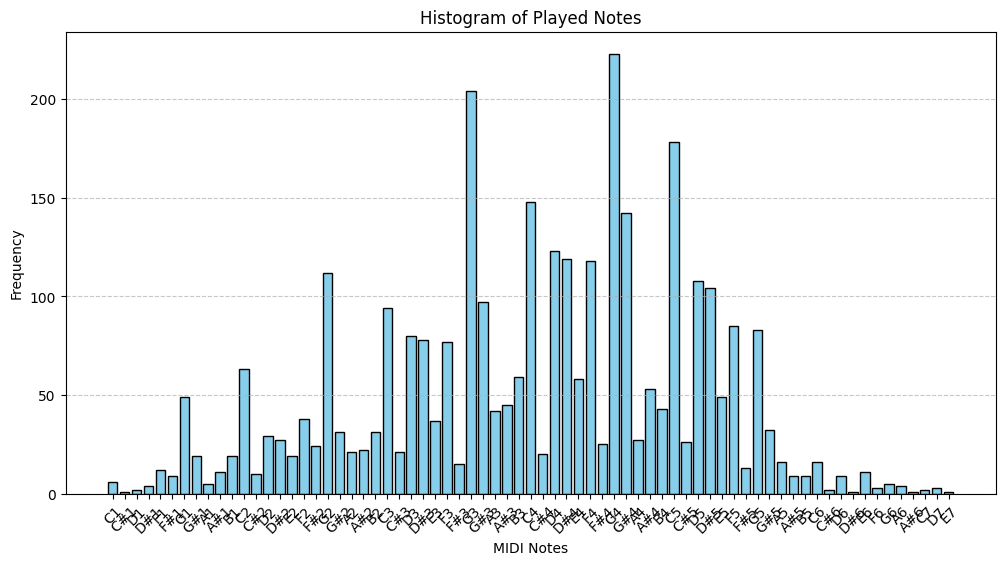

In [5]:

# Extract played notes
note_counts = Counter()

for track in midi_file.tracks:
    for msg in track:
        if msg.type == 'note_on' and msg.velocity > 0:  # Ignore note_off
            note_counts[msg.note] += 1  # Count note occurrences

# Sort notes
notes = sorted(note_counts.keys())
frequencies = [note_counts[n] for n in notes]

# Convert MIDI numbers to note names
def midi_to_note(midi_num):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = (midi_num // 12) - 1  # MIDI note number to octave
    note = note_names[midi_num % 12]
    return f"{note}{octave}"

note_labels = [midi_to_note(n) for n in notes]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.bar(note_labels, frequencies, color='skyblue', edgecolor='black')

plt.xlabel("MIDI Notes")
plt.ylabel("Frequency")
plt.title("Histogram of Played Notes")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [6]:
# Track note states
active_notes = {}  # Stores active notes {note: velocity}
time_series = []
timestamps = []
time_elapsed = 0

for msg in midi_file.tracks[1]:
    time_elapsed += msg.time
    
    if msg.type == 'note_on' and msg.velocity > 0:
        active_notes[msg.note] = msg.velocity  # Note is played with a velocity
    elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
        active_notes.pop(msg.note, None)  # Note is released
    
    # Snapshot at each time step
    timestamps.append(time_elapsed)
    snapshot = [active_notes.get(note, 0) for note in range(21, 109)]  # MIDI range (A0 to C8)
    time_series.append(snapshot)

# Convert to NumPy array
note_matrix = np.array(time_series)
print(note_matrix.shape)


(6961, 88)


In [7]:
# Apply PCA
pca = PCA(n_components=2)
fitted = pca.fit(note_matrix)
transformed = pca.fit_transform(note_matrix)
print(pca.components_)


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.71104995e-03
  -2.75423020e-05 -2.37995101e-04 -1.35561105e-03  0.00000000e+00
  -2.25491681e-03 -3.24005524e-03  2.03491845e-02  3.08145429e-03
   1.23913992e-02  1.35976050e-03 -1.96850856e-03 -2.11495901e-04
   4.49937530e-03  6.61395158e-02  4.38303708e-02  5.03869728e-02
   8.34199155e-02  3.57666664e-02  1.54791411e-01  3.33426335e-02
   1.04368429e-01  2.62178723e-02  1.05724301e-02  7.58273517e-02
   5.14916758e-02  1.51778404e-01  6.79650899e-02  1.46533574e-01
   1.17998412e-01  3.36047805e-02  1.59313244e-01  2.08148494e-02
   1.83934089e-01  4.46024466e-02  1.07053799e-01  1.27132120e-01
   6.47026793e-02  2.19585434e-01  6.11010168e-02  2.29242976e-01
   1.47383620e-01  3.29955918e-02  1.64774143e-01  5.42299573e-03
   1.66756714e-01  4.01145971e-02  1.12742827e-01  1.71297371e-01
   6.36394188e-02  2.69510905e-01  6.64858390e-02  2.57106771e-01
   2.77557698e-01  5.48475462e-02  2.36433505e-01  4.49707023e-02
   2.40306

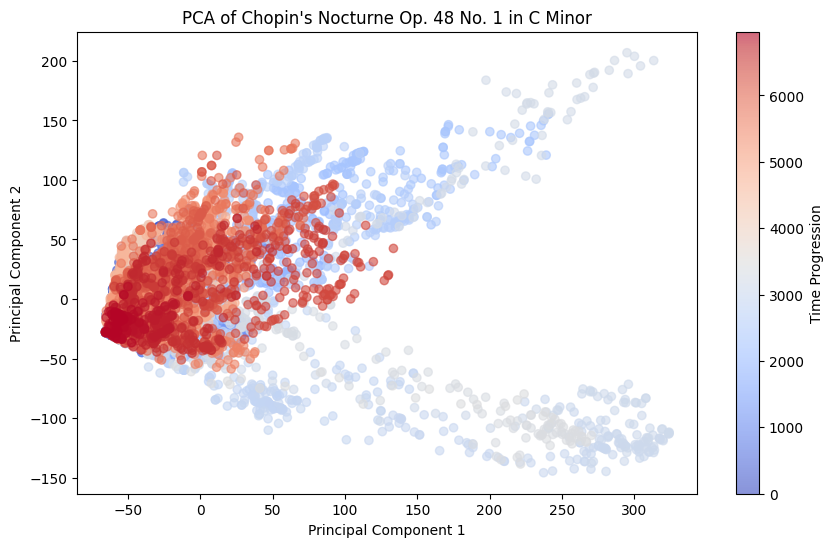

In [8]:
# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(transformed[:, 0], transformed[:, 1], alpha=0.6, c=range(len(transformed)), cmap='coolwarm')
plt.colorbar(label="Time Progression")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Chopin's Nocturne Op. 48 No. 1 in C Minor")
plt.show()

/Users/kevinhan/opt/anaconda3/envs/musicGen/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


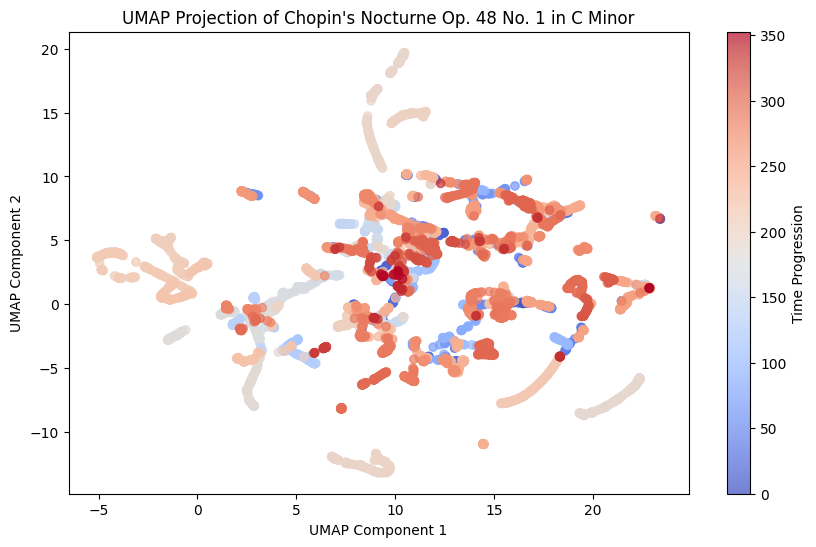

In [9]:
# Track note states
active_notes = {}  # Stores active notes {note: velocity}
time_series = []
timestamps = []
time_elapsed = 0

for msg in midi_file:
    time_elapsed += msg.time
    
    if msg.type == 'note_on' and msg.velocity > 0:
        active_notes[msg.note] = msg.velocity  # Note is played with a velocity
    elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
        active_notes.pop(msg.note, None)  # Note is released
    
    # Snapshot at each time step
    timestamps.append(time_elapsed)
    snapshot = [active_notes.get(note, 0) for note in range(21, 109)]  # MIDI range (A0 to C8)
    time_series.append(snapshot)

# Convert to NumPy array
note_matrix = np.array(time_series)

# Apply UMAP (reduce note matrix to 2D)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedded = reducer.fit_transform(note_matrix)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(embedded[:, 0], embedded[:, 1], c=timestamps, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Time Progression")
plt.title("UMAP Projection of Chopin's Nocturne Op. 48 No. 1 in C Minor")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


In [40]:
reconstructed = mido.MidiFile("/Users/kevinhan/Desktop/Independent Study/Music Analysis/reconstructed.mid")

In [43]:
total_reconstructed = ''
for i in reconstructed.tracks[1]:
    total_reconstructed += str(i)

In [17]:
total_original = ''
for i in midi_file.tracks[1]:
    total_original += str(i)

In [45]:
def find_differences(str1, str2):
    # Find the length of the shorter string
    min_len = min(len(str1), len(str2))
    
    # List to store the indices where the strings differ
    differences = []
    
    # Compare the strings character by character
    for i in range(min_len):
        if str1[i] != str2[i]:
            differences.append(i)
    
    # If one string is longer than the other, append the remaining indices
    if len(str1) != len(str2):
        differences.extend(range(min_len, max(len(str1), len(str2))))
    
    return differences

differences = find_differences(total_original, total_reconstructed)


In [59]:
print(midi_file)

MidiFile(type=1, ticks_per_beat=384, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('control_change', channel=0, control=64, value=127, time=1128),
    Message('control_change', channel=0, control=64, value=0, time=1644),
    Message('control_change', channel=0, control=64, value=127, time=115),
    Message('control_change', channel=0, control=64, value=0, time=16),
    Message('note_on', channel=0, note=48, velocity=47, time=49),
    Message('note_on', channel=0, note=36, velocity=36, time=8),
    Message('control_change', channel=0, control=64, value=127, time=27),
    Message('note_on', channel=0, note=79, velocity=67, time=800),
    Message('note_on', channel=0, note=63, velocity=39, time=26),
    Message('note_on', channel=0, note=55, velocity=33, time=0),
    Mess

In [60]:
print(reconstructed)

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('set_tempo', tempo=500000, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('control_change', channel=0, control=64, value=127, time=1128),
    Message('control_change', channel=0, control=64, value=0, time=1644),
    Message('control_change', channel=0, control=64, value=127, time=115),
    Message('control_change', channel=0, control=64, value=0, time=16),
    Message('note_on', channel=0, note=48, velocity=47, time=49),
    Message('note_on', channel=0, note=36, velocity=36, time=8),
    Message('control_change', channel=0, control=64, value=127, time=27),
    Message('note_on', channel=0, note=79, velocity=67, time=800),
    Message('note_on', channel=0, note=63, velocity=39, time=26),
    Message('note_on', channel=0, note=55, velocity=33, time=0),
    Mess

In [1]:
import os
import numpy as np

# Directory containing tokenized pieces
directory = "Chopin_Tokens"

# List to store lengths of all pieces
piece_lengths = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):  # Ensure we're reading only text files
        file_path = os.path.join(directory, filename)
        
        with open(file_path, "r") as file:
            tokens = file.readlines()  # Read all lines (tokens)
            piece_lengths.append(len(tokens))  # Store the number of tokens

# Compute statistics
mean_length = np.mean(piece_lengths)
std_dev = np.std(piece_lengths)
max_length = max(piece_lengths)
min_length = min(piece_lengths)

print(f"Total pieces: {len(piece_lengths)}")
print(f"Mean length: {mean_length:.2f} tokens")
print(f"Std dev: {std_dev:.2f} tokens")
print(f"Max length: {max_length} tokens")
print(f"Min length: {min_length} tokens")


Total pieces: 102
Mean length: 21352.17 tokens
Std dev: 31281.91 tokens
Max length: 174456 tokens
Min length: 993 tokens
